# Import and Pick Session

In [ ]:
from utils import get_dataset

# Get data for our stimulus 
STIMULI = ['static_gratings', 'drifting_gratings']
REGIONS = ['VISp', 'DG', 'LP', 'APN']
df = get_dataset(750332458, STIMULI, REGIONS)
print(f'There are {len(df)} rows in the dataset.')

# EDA

For this study, we analyzed two subsets of the 750332458 session dataset to investigate how different regions of the mouse brain respond to distinct visual stimuli. We focused on static and drifting gratings, as they are similar in nature but differ enough to potentially produce different neural responses. To examine regional differences in activity, we selected brain areas from the visual cortex and the hippocampus. Within the visual cortex, we chose the anteromedial visual area (VISam) and the primary visual cortex (VISp). For the hippocampus, we picked CA1 and CA3 to explore.

Let's start with a general overview of the data.

In [2]:
s_df.describe()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset,start_time,stop_time,duration,stimulus_condition_id,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,...,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,ecephys_structure_id,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_sampling_rate,probe_lfp_sampling_rate
count,698675.000000,6.986750e+05,6.986750e+05,698675.000000,698675.000000,698675.000000,698675.000000,698675.000000,698675.000000,698675.000000,...,698675.000000,698675.000000,6.986750e+05,698675.000000,698675.000000,52923.000000,52923.000000,52923.000000,698675.000000,698675.000000
mean,59170.532196,9.518152e+08,1.194545e-01,7421.028162,7421.278375,0.250213,4845.387913,0.535076,122.606277,0.018665,...,244.180980,32.523117,7.579046e+08,2456.403822,410.829954,8393.815959,3096.745423,8748.570886,29999.990855,1249.999619
std,7921.910814,1.701916e+03,7.088919e-02,1306.368527,1306.368523,0.000343,35.300848,0.164353,55.749051,0.025183,...,39.922177,20.143221,1.058377e+00,399.358832,90.226600,22.516979,39.520953,28.198790,0.019579,0.000816
min,49434.000000,9.518094e+08,7.471681e-07,5398.833208,5399.083416,0.250189,4787.000000,0.060225,26.217945,0.000008,...,111.000000,11.000000,7.579046e+08,1120.000000,385.000000,8360.000000,3054.000000,8706.000000,29999.922462,1249.996769
25%,51043.000000,9.518154e+08,5.858781e-02,5801.452884,5801.703090,0.250206,4815.000000,0.440795,90.610455,0.002289,...,244.000000,11.000000,7.579046e+08,2460.000000,385.000000,8360.000000,3061.000000,8706.000000,29999.996461,1249.999853
50%,56313.000000,9.518156e+08,1.129209e-01,7479.604772,7479.854981,0.250209,4844.000000,0.553489,106.144155,0.005789,...,250.000000,27.000000,7.579046e+08,2520.000000,385.000000,8403.000000,3081.000000,8761.000000,29999.996461,1249.999853
75%,68799.000000,9.518158e+08,1.797922e-01,8753.919281,8754.169495,0.250214,4876.000000,0.584168,143.003445,0.030241,...,258.000000,59.000000,7.579046e+08,2600.000000,385.000000,8414.000000,3156.000000,8773.000000,29999.996461,1249.999853
max,70389.000000,9.518170e+08,2.786248e-01,9151.751624,9152.001828,0.283580,4907.000000,1.784530,304.189470,0.091270,...,297.000000,59.000000,7.579046e+08,2980.000000,726.000000,8417.000000,3156.000000,8777.000000,29999.996461,1249.999853


In [3]:
d_df.describe()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset,start_time,stop_time,duration,stimulus_condition_id,waveform_PT_ratio,waveform_amplitude,amplitude_cutoff,...,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,ecephys_structure_id,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_sampling_rate,probe_lfp_sampling_rate
count,504666.000000,5.046660e+05,504666.000000,504666.000000,504666.000000,504666.000000,504666.000000,504666.000000,504666.000000,504666.000000,...,504666.000000,504666.000000,5.046660e+05,504666.000000,504666.000000,51500.000000,51500.000000,51500.000000,504666.000000,504666.000000
mean,27694.347152,9.518150e+08,0.994448,3438.409230,3440.410902,2.001672,266.094248,0.524836,129.264442,0.020084,...,239.479973,32.082585,7.579046e+08,2409.265970,419.798263,8392.282427,3099.432971,8746.638272,29999.988909,1249.999538
std,18624.572280,1.923753e+03,0.586001,1307.136107,1307.136106,0.000018,11.848266,0.181618,58.396364,0.025904,...,43.937285,20.782017,1.210845e+00,439.745099,103.224559,23.107440,40.550284,28.951066,0.022400,0.000933
min,3798.000000,9.518094e+08,0.000001,1585.647748,1587.649398,2.001610,246.000000,0.060225,26.217945,0.000008,...,111.000000,11.000000,7.579046e+08,1120.000000,385.000000,8360.000000,3054.000000,8706.000000,29999.922462,1249.996769
25%,3937.000000,9.518154e+08,0.469487,2002.996362,2004.998052,2.001660,256.000000,0.440795,92.643330,0.001697,...,234.000000,11.000000,7.579046e+08,2360.000000,385.000000,8360.000000,3061.000000,8706.000000,29999.996461,1249.999853
50%,31100.000000,9.518156e+08,0.999853,3474.225432,3476.227112,2.001670,266.000000,0.526429,110.586255,0.005789,...,250.000000,27.000000,7.579046e+08,2520.000000,385.000000,8403.000000,3081.000000,8761.000000,29999.996461,1249.999853
75%,49252.000000,9.518157e+08,1.504583,4855.379222,4857.380892,2.001680,277.000000,0.577503,148.308615,0.035212,...,257.000000,59.000000,7.579046e+08,2580.000000,385.000000,8414.000000,3156.000000,8773.000000,29999.996461,1249.999853
max,49432.000000,9.518170e+08,2.001661,5395.830692,5397.832372,2.001740,286.000000,1.784530,304.189470,0.091270,...,297.000000,59.000000,7.579046e+08,2980.000000,726.000000,8417.000000,3156.000000,8777.000000,29999.996461,1249.999853


In [4]:
d_df.columns

Index(['stimulus_presentation_id', 'unit_id',
       'time_since_stimulus_presentation_onset', 'stimulus_block',
       'start_time', 'stop_time', 'orientation', 'phase', 'temporal_frequency',
       'stimulus_name', 'contrast', 'spatial_frequency', 'size', 'duration',
       'stimulus_condition_id', 'waveform_PT_ratio', 'waveform_amplitude',
       'amplitude_cutoff', 'cluster_id', 'cumulative_drift', 'd_prime',
       'firing_rate', 'isi_violations', 'isolation_distance', 'L_ratio',
       'local_index', 'max_drift', 'nn_hit_rate', 'nn_miss_rate',
       'peak_channel_id', 'presence_ratio', 'waveform_recovery_slope',
       'waveform_repolarization_slope', 'silhouette_score', 'snr',
       'waveform_spread', 'waveform_velocity_above', 'waveform_velocity_below',
       'waveform_duration', 'filtering', 'probe_channel_number',
       'probe_horizontal_position', 'probe_id', 'probe_vertical_position',
       'structure_acronym', 'ecephys_structure_id',
       'ecephys_structure_acronym'

There are 41 columns capturing information about the neural response to the stimulus presentation, such as stimulus characteristics, neural unit responses, waveform features, probe position, and location in the brain. The unique identifier for this table, the `unit_id` represents the neural unit. Since there is no guarantee that a single neuron is measured, the neural unit represents single or multiple neurons.

### Neural Response & Quality Metrics

The data, by default, is already filtered with appropriate values for `isi_violations`, `amplitude_cutoff`, `presence_ratio`. These variables measure the refractory period violations, the proportion of missed spikes, and the fraction of the time that the unit is detected throughout the recording respectively. In addition to this, there are other metrics which help to understand the quality of our data such as: `firing_rate`, `snr`, `isolation_distance`, `d_prime`, `nn_hit_rate`/`nn_miss_rate`. The Allen Brain Observatory provides the boxplots for these metrics to contextualize our results. Finally, we have `L_ratio`, `local_index`, `cluster_id`, and `filtering` which provide details on the quality of the recorded response.

### Waveform Features

This next group of variables describe the shape and properties of the spike waveforms:

`waveform_PT_ratio`: Peak-to-trough amplitude ratio.

`waveform_amplitude`: Amplitude of the waveform.

`waveform_duration`: Duration of the spike waveform.

`waveform_recovery_slope`: Slope after the waveform trough (recovery phase).

`waveform_repolarization_slope`: Slope leading to the trough.

`waveform_spread`: Spatial extent of waveform across electrodes.

`waveform_velocity_above`, `waveform_velocity_below`: Velocity of waveform propagation.

### Stimulus Presentation Info

The dataset includes the `stimulus_presentation_id` and `stimulus_name` which we've filtered to be *static_gratings* and *drifting_gratings*. For each stimulus, we get information on its `orientation`, `phase`, `contrast`, `size`, and `duration`. The `temporal_frequency` and `spatial_frequency` are also available.

### Probe & Recording Info

Probes are the apparatus used to record the neural responses. The unique identifier is the `probe_id`, and there is also a `probe_description`. Some more info:

`probe_channel_number`: Channel on the probe.

`peak_channel_id`: Channel with peak unit activity.

`probe_horizontal_position`, `probe_vertical_position`: Position on the probe grid.

`probe_sampling_rate`, `probe_lfp_sampling_rate`: Sampling rates (for spikes and LFPs).

`probe_has_lfp_data`: Boolean, whether local field potential data is available.


### Anatomical Mapping

These columns link the recorded neural data to the anatomical regions in the Allen Common Coordinate Framework (CCF), allowing mapping to specific brain structures and 3D spatial localization:

`structure_acronym`: Acronym of the brain structure.

`ecephys_structure_acronym`: Brain structure acronym aligned with electrophysiology data.

`ecephys_structure_id`: Integer ID for the brain region.

`anterior_posterior_ccf_coordinate`: Position along the anterior-posterior axis (µm).

`dorsal_ventral_ccf_coordinate`: Position along the dorsal-ventral axis (µm).

`left_right_ccf_coordinate`: Position along the left-right axis (µm).

`location`: Text label of the anatomical location (may combine region and layer).

### Temporal Tracking & Drift

These final features track when recordings occurred and how stable the recording was across time:

`start_time`, `stop_time`: Start and stop times of the stimulus or recording window (relative to session start).

`cumulative_drift`: Total drift in unit position over the session (likely due to tissue movement).

`max_drift`: Maximum displacement observed for the unit during recording.

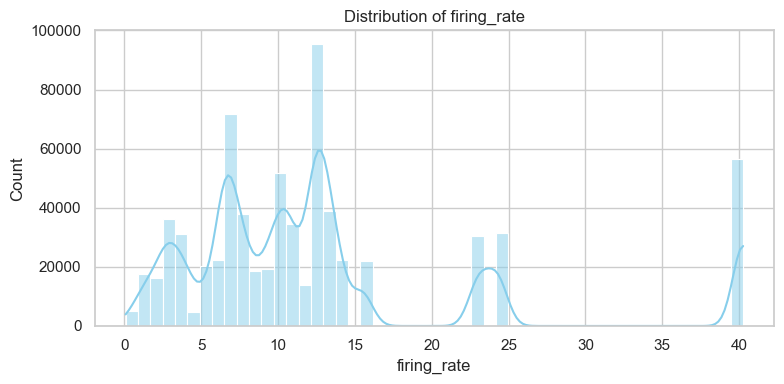

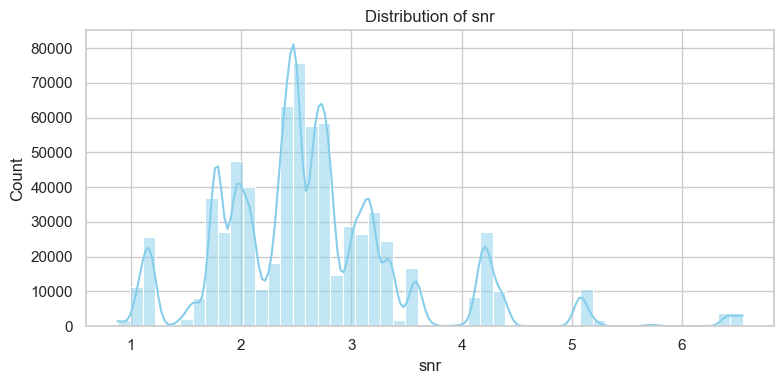

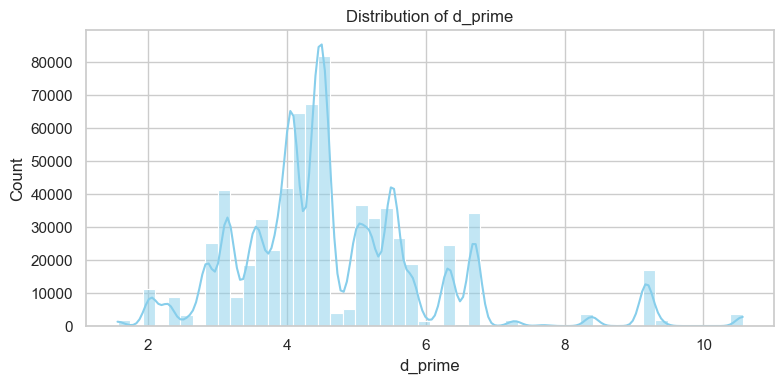

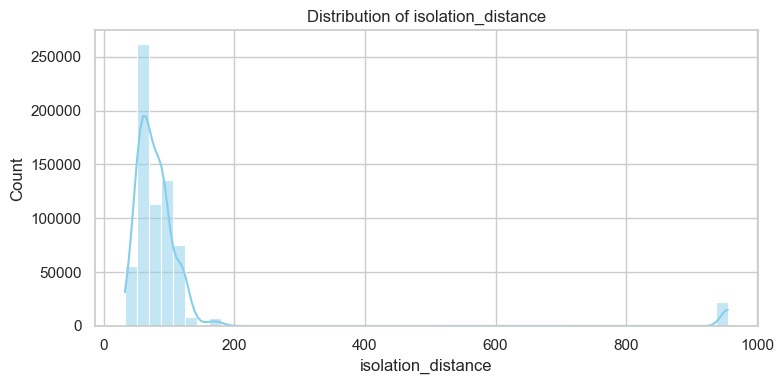

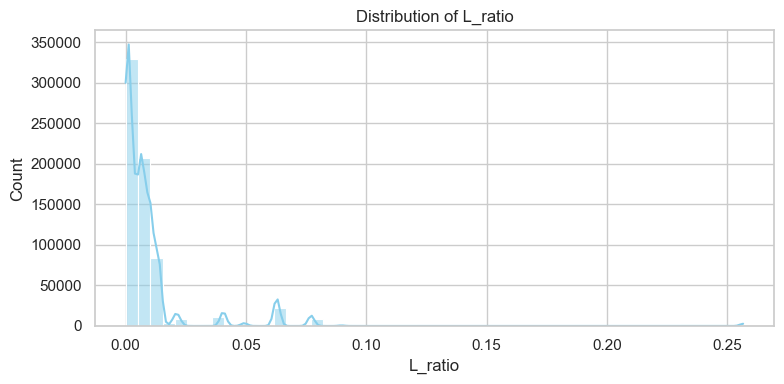

/var/folders/9g/q67r0bss7297jh57g7_vdqsm0000gn/T/ipykernel_75535/2458667690.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


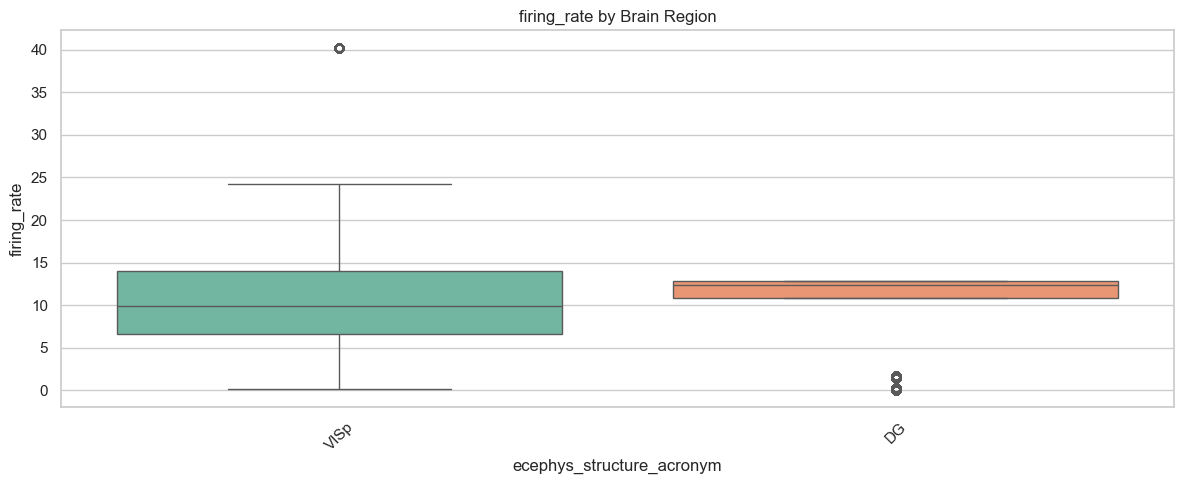

/var/folders/9g/q67r0bss7297jh57g7_vdqsm0000gn/T/ipykernel_75535/2458667690.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


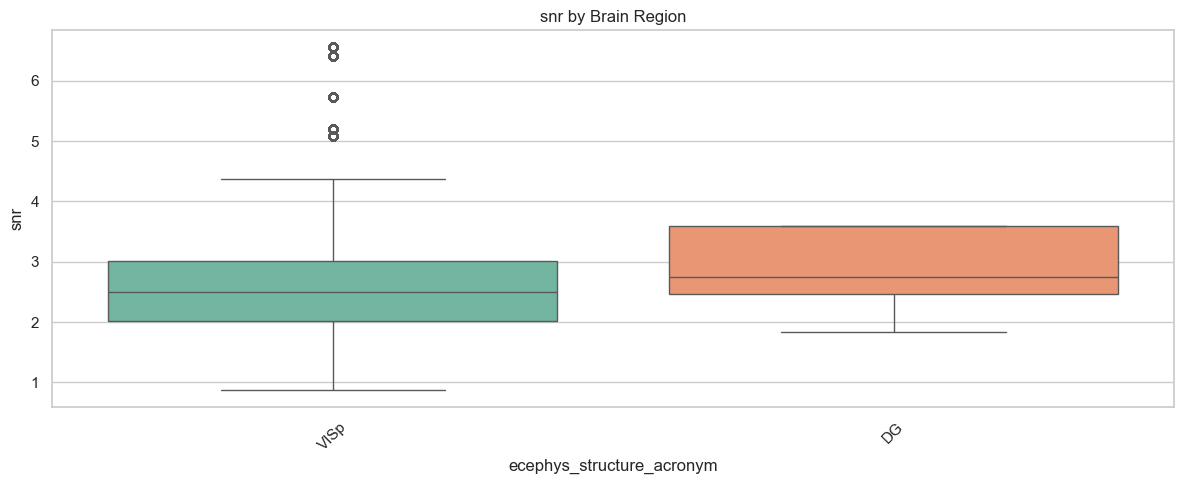

/var/folders/9g/q67r0bss7297jh57g7_vdqsm0000gn/T/ipykernel_75535/2458667690.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/opt/anaconda3/envs/allensdk/lib/python3.11/site-packages/seaborn/_base.py:1007: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_data.insert(0, var, comp_col)


ValueError: cannot reindex on an axis with duplicate labels

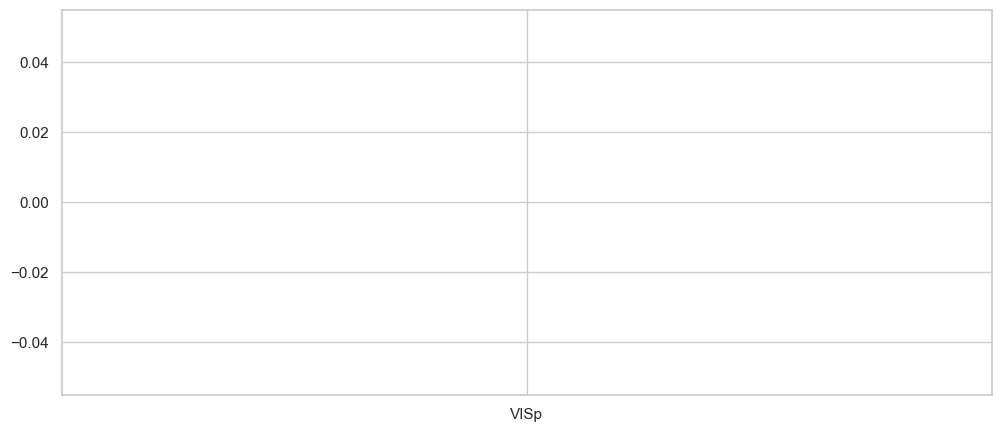

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of quality metrics
quality_metrics = [
    'firing_rate', 'snr', 'd_prime',
    'isolation_distance', 'L_ratio'
]

# Set seaborn style
sns.set(style="whitegrid")

# 1. HISTOGRAMS/KDE PLOTS
for metric in quality_metrics:
    plt.figure(figsize=(8, 4))
    sns.histplot(s_df[metric], kde=True, bins=50, color="skyblue")
    plt.title(f"Distribution of {metric}")
    plt.xlabel(metric)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# 2. BOXPLOTS GROUPED BY BRAIN REGION
for metric in quality_metrics:
    plt.figure(figsize=(12, 5))
    # You may want to filter to regions with enough units
    top_regions = s_df['ecephys_structure_acronym'].value_counts().index[:10]
    sns.boxplot(
        data=s_df[s_df['ecephys_structure_acronym'].isin(top_regions)],
        x='ecephys_structure_acronym',
        y=metric,
        palette='Set2'
    )
    plt.title(f"{metric} by Brain Region")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
